In [ ]:
# default_exp datasets

# ClaireExpt6 Dataset

```
Important to keep track of difference between nans and 0s. In Lag-CRPs, nans are impossible, 0s are no lag transition.

data.recall
0 is intrusion
Nan is "empty"

data.condition
0 is control
1 is retrieval practice
NaN is excluded

data.recall_itemnos
0 is "empty"
nonzero values are study positions

data.cond_control identies control condition variables
data.cond_rp identifies rp condition variables

row is trial
column is
1 is 
(column numbers, each row corresponds to a trial)
1: 'subjects'	
2: 'session'	
3: 'condition'	
4: 'retrieval practice success' %  retrieval practice success of the 3 items 
% free recall data %
5: 'recall_overall'	% free recall trial 
6:'recall_critical'	% 7, 13, 19
7:'recall_(-1)neighbors'	
8:'recall_(+1)neighbors'	
9:'recall_neighbors' % recall of all neighbors 	
[]	[]	
12:'conditional_recall_critical' % conditional on successful retrieval during rp
13:'conditional_recall_(-1)neighbors'	
14:'conditional_recall_(+1)neighbors'

rp_itemnos
NaNs identify control trials
0s identify unsuccessful retrieval practice

% simulation parameters 
param.B_recall = 1;
% this was a pretty good value
% param.B_practice = 0.1;
param.B_practice = 0.6;
param.B_enc = 0.7;
param.B_rec = param.B_recall; % the higher it is the more context
param.B_ri = 1; %1 = distraction completely overwrites context 
% not sure which primacy mechanism to use
param.P1 = 0.3;
param.P2 = 1;
param.B_s = 0.2;
param.B_s_always = 0;
param.Dfc = 0.8;
%param.Dcf = 0.8;
% param.stop_rule = 'ratio';
param.stop_rule = 'op';
param.sampling_rule = 'classic';
param.lat_inh = 0;
param.T = 0.4;
% param.Dfc = 0.35;
param.Dcf = 0.0;

% learning during recall on (this is the key difference in the model for
% with retreival practice)
param.Lrfc = 0;
param.Lrcf = 0.15; % how likley will the retreival practiced items be remembered 


% Selective Retrieval Practice of three items (items studied in 7th, 13th
% and 19th positions)
critical_items_rp = [7 13 19];
critical_items_control = [0];

param.X1 = 0.001;
param.X2 = .4; % using op

% fill in any missing parameters
param = check_param_cmrx(param);
```

In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd
from psifr import fr

from compmemlearn.datasets import simulate_array_from_presentations
from compmemlearn.models import Classic_CMR
from scipy.optimize import differential_evolution
from numba import njit
import numpy as np
from numba import int32
from compmemlearn.analyses import flex_mixed_spc, flex_mixed_crp, flex_mixed_pfr, fast_csp, alternative_contiguity, rpl
import matplotlib.pyplot as plt

In [ ]:
# export

def prepare_clairexpt6_data(main_path, rp_itemnos_path):

    # load all the data
    matfile = sio.loadmat(main_path, squeeze_me=True)['data'].item()
    trials = matfile[4].astype('int64') # cleaner version, wo intrusions
    subjects = matfile[1].astype('int64')
    condition = matfile[2].astype('int64')
    cond_rp = matfile[5] # identifies rp condition variables
    cond_control = matfile[6] # identifies control condition variables
    list_length = matfile[3]

    # item sequences for rp condition
    rp_sequences = sio.loadmat(rp_itemnos_path, squeeze_me=True)['rp_itemnos'].astype('int64')

    data = []
    for trial_index, trial in enumerate(trials):

        # skip further processing if subject is coded as negative number
        if subjects[trial_index] < 0:
            continue
        
        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1

        # add normal study events
        for i in range(list_length):
            data += [[subjects[trial_index], list_index, 'study', i+1, i+1, condition[trial_index]]]

        # if applicable, add rp events
        if condition[trial_index]:
            for i in range(3):
                if rp_sequences[trial_index, i]:
                    data += [[subjects[trial_index], list_index, 'study', rp_sequences[trial_index, i], rp_sequences[trial_index, i], condition[trial_index]]]

        # and recall events
        for recall_index, recall_event in enumerate(trial):
            if recall_event != 0:
                data += [[subjects[trial_index], list_index,
                          'recall', recall_index+1, recall_event, condition[trial_index]]]

    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item', 'condition'])

    merged = fr.merge_free_recall(data, list_keys=['condition'])
    rp_sequences[rp_sequences <= 0] = 0
    presentations = np.hstack((np.matlib.repmat(np.arange(list_length)+1, len(rp_sequences), 1), rp_sequences))

    return trials, merged, list_length, presentations, condition, data, subjects[subjects>0], cond_rp, cond_control

In [ ]:
trials, events, list_length, presentations, list_types, rep_data, subjects, cond_rp, cond_control = prepare_clairexpt6_data("../../data/data_exp6.mat", "../../data/rp_success.mat")

## Data Overview

In [ ]:
import numpy as np
from numba import njit, prange
from compmemlearn.models import Classic_CMR
from numba.typed import Dict
from numba.core import types

@njit(fastmath=True, nogil=True, parallel=True)
def lohnas_data_likelihood(trials, presentations, model_class, parameters):

    list_length = len(presentations[0])
    likelihood = np.ones((len(trials), list_length))

    for trial_index in prange(len(trials)):

        item_count = np.max(presentations[trial_index])
        trial = trials[trial_index]
        model = model_class(item_count, list_length, parameters)
        presentation = presentations[trial_index][presentations[trial_index] > 0] -1 ## modify to support odd indexing
        model.experience(model.items[presentation])

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentation[trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities()[recall] + 10e-7

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def lohnas_objective_function(data_to_fit, presentations, model_class, fixed_parameters, free_parameters):

    """
    Generates and returns an objective function for input to support search 
    through parameter space for model fit using an optimization function.

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of likelihood using the model 
    class, all parameters, and provided data.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value

    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return lohnas_data_likelihood(data_to_fit, presentations, model_class, parameters)

    return objective_function

## Condition-Wise Fitting

In [ ]:
cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
]

conditions = ['Control', 'RP']

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cmr_results = []
for condition in [0, 1]:
    selection = list_types == condition
    cost_function = lohnas_objective_function(
        trials[selection], 
        presentations[selection],
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'delay_drift_rate': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=True))

differential_evolution step 1: f(x)= 5050.66
differential_evolution step 2: f(x)= 3739.1
differential_evolution step 3: f(x)= 3280.2
differential_evolution step 4: f(x)= 3280.2
differential_evolution step 5: f(x)= 3158.42
differential_evolution step 6: f(x)= 3158.42
differential_evolution step 7: f(x)= 3133.04
differential_evolution step 8: f(x)= 3122.74
differential_evolution step 9: f(x)= 3122.74
differential_evolution step 10: f(x)= 3114.31
differential_evolution step 11: f(x)= 3114.31
differential_evolution step 12: f(x)= 3106.81
differential_evolution step 13: f(x)= 3106.81
differential_evolution step 14: f(x)= 3106.81
differential_evolution step 15: f(x)= 3103.33
differential_evolution step 16: f(x)= 3083.54
differential_evolution step 17: f(x)= 3042.02
differential_evolution step 18: f(x)= 3042.02
differential_evolution step 19: f(x)= 3033.52
differential_evolution step 20: f(x)= 3007.12
differential_evolution step 21: f(x)= 3007.12
differential_evolution step 22: f(x)= 3007.12


In [ ]:
cmr_results

[     fun: 2975.134867581669
      jac: array([-0.06730261, -0.19517756, -0.01059561,  0.04656613, -0.01514309,
        -9.09153637,  7.70419319,  0.        ,  0.07862582, -0.03537934,
        -0.04138201])
  message: 'Optimization terminated successfully.'
     nfev: 7377
      nit: 40
  success: True
        x: array([6.94621761e-01, 9.00820304e-01, 8.27694497e-01, 6.29486794e-01,
        8.02814419e-02, 1.00000000e+00, 2.22044605e-16, 6.19704899e+01,
        4.03765537e-02, 1.29131693e-01, 5.84921887e+00]),
      fun: 3160.6782599545445
      jac: array([ 0.05397851, -0.10190888, -0.00568434,  0.00204636, -0.00422915,
         0.00104592, -0.00304681,  0.01127773,  0.02678462,  0.01732587,
        -0.00927685])
  message: 'Optimization terminated successfully.'
     nfev: 6900
      nit: 31
  success: True
        x: array([0.77422693, 0.84571273, 0.82856235, 0.13214982, 0.88051187,
        0.29551315, 4.76381681, 0.31516321, 0.03725594, 0.12108304,
        1.3268154 ])]

In [ ]:
from numba import int32

@njit(nogil=True)
def simulate_array_from_presentations(model_class, parameters, presentations, experiment_count):

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            #presentation = presentations[trial_index]
            presentation = presentations[trial_index][presentations[trial_index] > 0] -1
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            recalled = model.free_recall()
            
            for i in range(len(recalled)):
                trials[experiment*len(presentations) + trial_index, i] = find_first(recalled[i], presentation) + 1
    
    return trials

@njit(nogil=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

In [ ]:
# simulate data corresponding to each cmr_result

from numba.typed import Dict
from numba.core import types
from numpy import matlib

experiment_count = 1000

sim_trials = []
sim_presentations = []
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

for i, cmr_result in enumerate(cmr_results):

    for j in range(len(cmr_result.x)):
        fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
        
    fitted_parameters['sampling_rule'] = 0
    fitted_parameters['mfc_familiarity_scale'] = 0
    fitted_parameters['mcf_familiarity_scale'] = 0
    fitted_parameters['drift_familiarity_scale'] = 0
    fitted_parameters['delay_drift_rate'] = 0

    sim_trials.append(simulate_array_from_presentations(
        init_cmr, fitted_parameters, presentations[list_types==i], experiment_count))
    sim_presentations.append(np.matlib.repmat(presentations[list_types==i], experiment_count, 1))

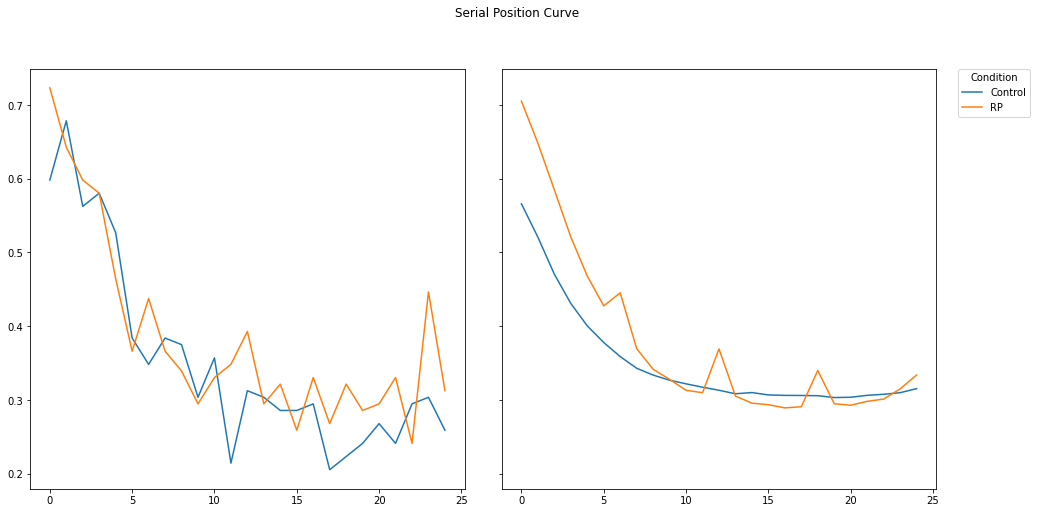

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(2):
    
    test_spc= flex_mixed_spc(trials[list_types==condition], presentations[list_types==condition, :-3])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition][:, :-3])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

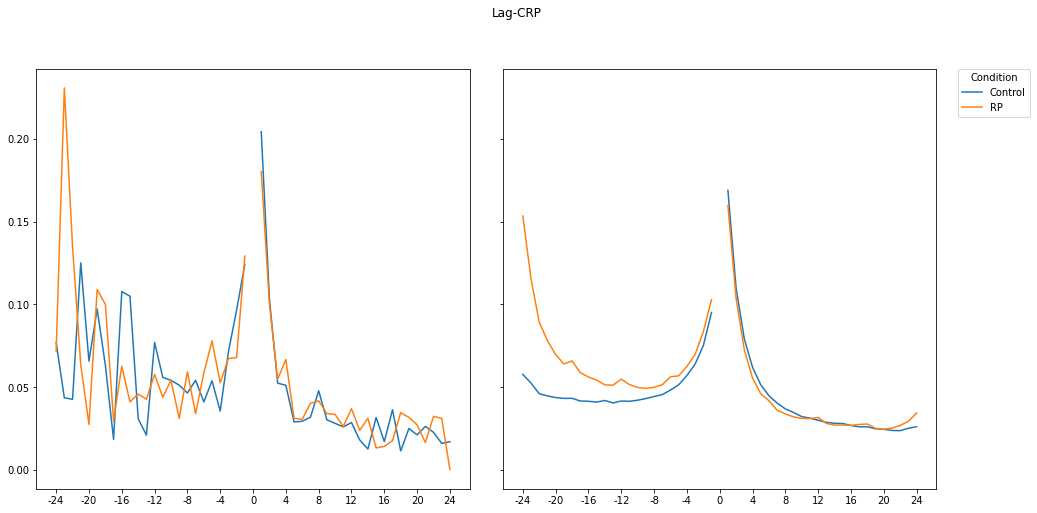

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

item_count = 25
for condition in range(2):

    test_crp= flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition, :-3])
    test_crp[item_count-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition][:, :-3])
    sim_crp[item_count-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - (item_count - 1))
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - (item_count - 1))
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

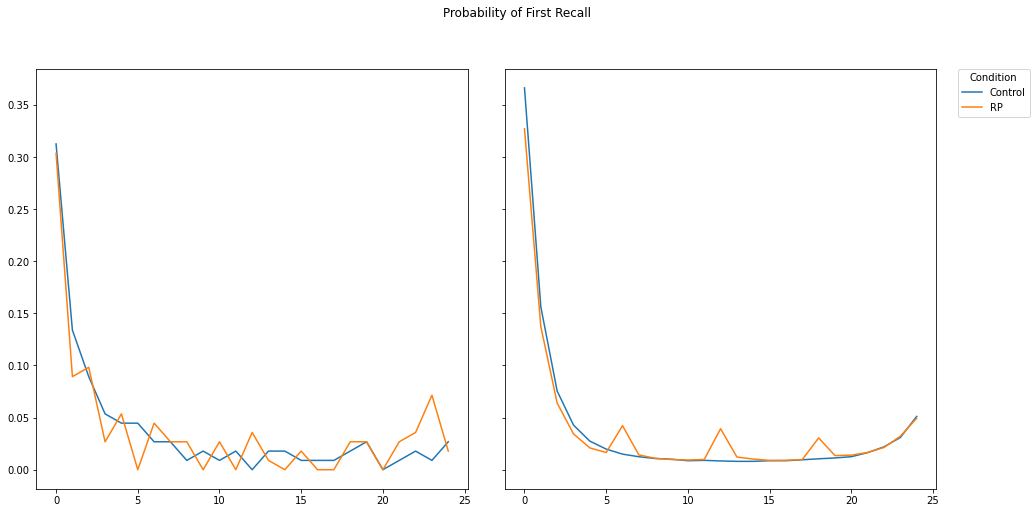

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(2):

    test_pfr = flex_mixed_pfr(trials[list_types==condition], presentations[list_types==condition, :-3])
    axes[0].plot(np.arange(len(test_pfr)), test_pfr, label=conditions[condition])

    sim_pfr = flex_mixed_pfr(sim_trials[condition], sim_presentations[condition][:, :-3])
    axes[1].plot(np.arange(len(sim_pfr)), sim_pfr, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
fig.suptitle("Probability of First Recall")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

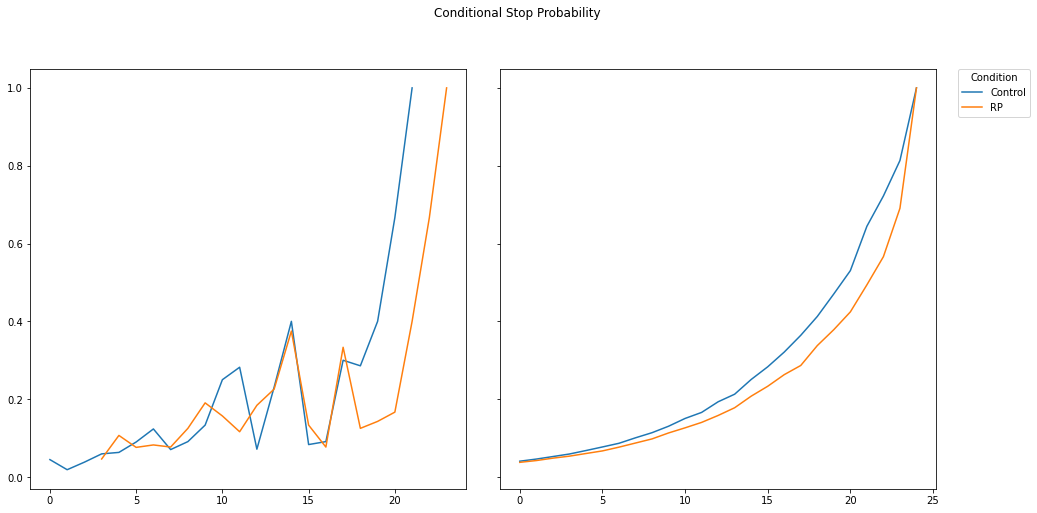

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(2):
    test_csp = fast_csp(trials[list_types==condition], list_length)
    test_csp[test_csp==0] = np.nan
    axes[0].plot(np.arange(list_length+1), test_csp, label=conditions[condition])

    sim_csp = fast_csp(sim_trials[condition], list_length)
    sim_csp[sim_csp==0] = np.nan
    axes[1].plot(np.arange(list_length+1), sim_csp, label=conditions[condition])

#plt.xlabel('Recall Position')
#plt.ylabel('Conditional Stop Probability')
fig.suptitle('Conditional Stop Probability')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)